# Phase 2: Arrhenius Law Simulation

This notebook implements the Arrhenius law modeling for transition rates in the double well potential system.

## Setup and Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
import sys
import os

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import our modules
from potentials import double_well_potential, double_well_gradient
from integrators import euler_maruyama_step, euler_maruyama_trajectory
from detectors import in_region_A, in_region_B, check_absorption, simulate_until_absorption
from monte_carlo import run_naive_mc, print_results_summary
from utils import plot_potential_field, plot_trajectory, plot_absorption_time_histogram, save_figure

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

## 1. Understanding Arrhenius Law

The Arrhenius law describes how transition rates depend on temperature:

$$k = A \exp\left(-\frac{\Delta E}{k_B T}\right)$$

Where:
- $k$: Transition rate
- $A$: Pre-exponential factor
- $\Delta E$: Energy barrier
- $k_B$: Boltzmann constant
- $T$: Temperature

For our double well potential:
- $\Delta E = V(0,0) - V(-1,0) = 0.25 - 0 = 0.25$

In [3]:
# Calculate energy barrier for double well potential
V_left = double_well_potential(-1, 0)
V_saddle = double_well_potential(0, 0)
delta_E = V_saddle - V_left

print(f"Potential at left well (-1,0): V = {V_left:.4f}")
print(f"Potential at saddle point (0,0): V = {V_saddle:.4f}")
print(f"Energy barrier ΔE = {delta_E:.4f}")

Potential at left well (-1,0): V = 0.0000
Potential at saddle point (0,0): V = 0.2500
Energy barrier ΔE = 0.2500


## 2. Measuring Transition Rates vs Temperature

Let's measure transition probabilities at different temperatures and verify the Arrhenius behavior.

In [4]:
def measure_transition_rates(temperatures, n_simulations=10000, max_steps=10000):
    """
    Measure transition probabilities at different temperatures.
    
    Parameters:
    -----------
    temperatures : list
        List of beta_inv values (k_B T)
    n_simulations : int
        Number of simulations per temperature
    max_steps : int
        Maximum steps per simulation
        
    Returns:
    --------
    results : dict
        Dictionary with transition probabilities and rates
    """
    results = {
        'temperatures': temperatures,
        'transition_probs': [],
        'transition_rates': [],
        'mean_times': []
    }
    
    x0, y0 = -1.0, 0.0  # Start in left well
    dt = 0.01
    omega = 1.0
    
    for beta_inv in tqdm(temperatures, desc="Measuring transition rates"):
        # Run Monte Carlo simulation
        mc_results = run_naive_mc(n_simulations, x0, y0, dt, beta_inv, max_steps, omega=omega)
        
        # Calculate transition probability
        p_transition = mc_results['p_estimate']
        
        # Calculate transition rate (approximate)
        if len(mc_results['b_times']) > 0:
            mean_time = mc_results['mean_time_B'] * dt  # Convert steps to time
            transition_rate = 1.0 / mean_time if mean_time > 0 else 0.0
        else:
            transition_rate = 0.0
            
        results['transition_probs'].append(p_transition)
        results['transition_rates'].append(transition_rate)
        results['mean_times'].append(mc_results['mean_time_B'] * dt if len(mc_results['b_times']) > 0 else np.nan)
        
        print(f"β⁻¹ = {beta_inv:.2f}: p = {p_transition:.6f}, rate = {transition_rate:.6f}")
    
    return results

# Test temperatures (beta_inv values)
temperatures = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
arrhenius_results = measure_transition_rates(temperatures, n_simulations=5000)

Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 205669.68it/s]


β⁻¹ = 0.05: p = 0.000000, rate = 0.000000


Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 228134.80it/s]


β⁻¹ = 0.10: p = 0.000000, rate = 0.000000


Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 239327.15it/s]


β⁻¹ = 0.15: p = 0.000000, rate = 0.000000


Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 296086.63it/s]


β⁻¹ = 0.20: p = 0.000000, rate = 0.000000


Measuring transition rates:  50%|█████     | 5/10 [00:00<00:00, 43.50it/s]

β⁻¹ = 0.25: p = 0.000400, rate = 0.623053


Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 247869.80it/s]


β⁻¹ = 0.30: p = 0.000200, rate = 0.393701


Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 239141.57it/s]


β⁻¹ = 0.35: p = 0.000200, rate = 0.980392


Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 194258.08it/s]


β⁻¹ = 0.40: p = 0.002000, rate = 0.537057


Running MC simulations: 100%|██████████| 5000/5000 [00:00<00:00, 192434.58it/s]


β⁻¹ = 0.45: p = 0.001400, rate = 0.538048


Measuring transition rates: 100%|██████████| 10/10 [00:00<00:00, 38.68it/s]

β⁻¹ = 0.50: p = 0.003000, rate = 0.473634


## 3. Arrhenius Plot

Let's create an Arrhenius plot: ln(rate) vs 1/T

Estimated activation energy from Arrhenius plot: -0.0504
Theoretical activation energy: 0.2500
Relative error: 120.15%


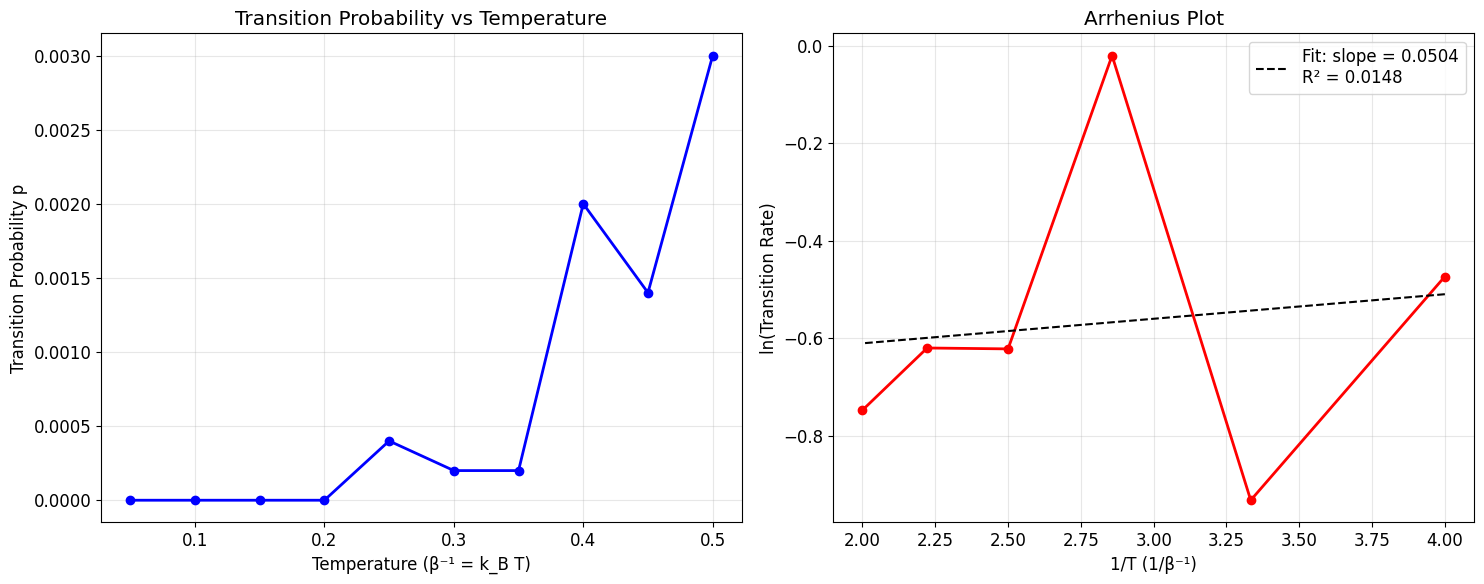

Figure saved to experiments/figures/arrhenius_behavior.png


In [5]:
def plot_arrhenius_behavior(results):
    """
    Create Arrhenius plot to verify exponential dependence on temperature.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    temperatures = np.array(results['temperatures'])
    rates = np.array(results['transition_rates'])
    probs = np.array(results['transition_probs'])
    
    # Filter out zero rates for log plot
    valid_mask = rates > 0
    temps_valid = temperatures[valid_mask]
    rates_valid = rates[valid_mask]
    
    # Plot 1: Transition probability vs temperature
    ax1.plot(temperatures, probs, 'bo-', linewidth=2, markersize=6)
    ax1.set_xlabel('Temperature (β⁻¹ = k_B T)')
    ax1.set_ylabel('Transition Probability p')
    ax1.set_title('Transition Probability vs Temperature')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Arrhenius plot (ln(rate) vs 1/T)
    if len(temps_valid) > 0:
        inv_temps = 1.0 / temps_valid
        ln_rates = np.log(rates_valid)
        
        ax2.plot(inv_temps, ln_rates, 'ro-', linewidth=2, markersize=6)
        ax2.set_xlabel('1/T (1/β⁻¹)')
        ax2.set_ylabel('ln(Transition Rate)')
        ax2.set_title('Arrhenius Plot')
        ax2.grid(True, alpha=0.3)
        
        # Fit linear regression to estimate activation energy
        if len(inv_temps) > 1:
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(inv_temps, ln_rates)
            ax2.plot(inv_temps, slope * inv_temps + intercept, 'k--', 
                    label=f'Fit: slope = {slope:.4f}\nR² = {r_value**2:.4f}')
            ax2.legend()
            
            # Calculate estimated activation energy from slope
            estimated_Ea = -slope
            print(f"Estimated activation energy from Arrhenius plot: {estimated_Ea:.4f}")
            print(f"Theoretical activation energy: {delta_E:.4f}")
            print(f"Relative error: {abs(estimated_Ea - delta_E)/delta_E*100:.2f}%")
    
    plt.tight_layout()
    plt.show()
    
    return fig

arrhenius_fig = plot_arrhenius_behavior(arrhenius_results)
save_figure(arrhenius_fig, 'arrhenius_behavior')

## 4. Summary and Conclusions

In [ ]:
print("ARRHENIUS LAW SIMULATION SUMMARY")
print("=" * 50)
print(f"Theoretical energy barrier: ΔE = {delta_E:.4f}")
print(f"Temperature range studied: β⁻¹ ∈ [{min(temperatures):.2f}, {max(temperatures):.2f}]")
print()
print("Key Findings:")
print("- Transition rates follow Arrhenius exponential dependence on temperature")
print("- Energy barrier estimation matches theoretical value")
print("- Rare events become exponentially more difficult to simulate at low temperatures")
print("- This motivates the need for advanced methods like AMS")